In [1]:
## Import Statements
import numpy as np
import matplotlib.pyplot as plt
from src.map_image import *
from src.map_instance import *
from src.map_data import *
from src.map_transforms import *

%config InlineBackend.figure_format = 'retina'

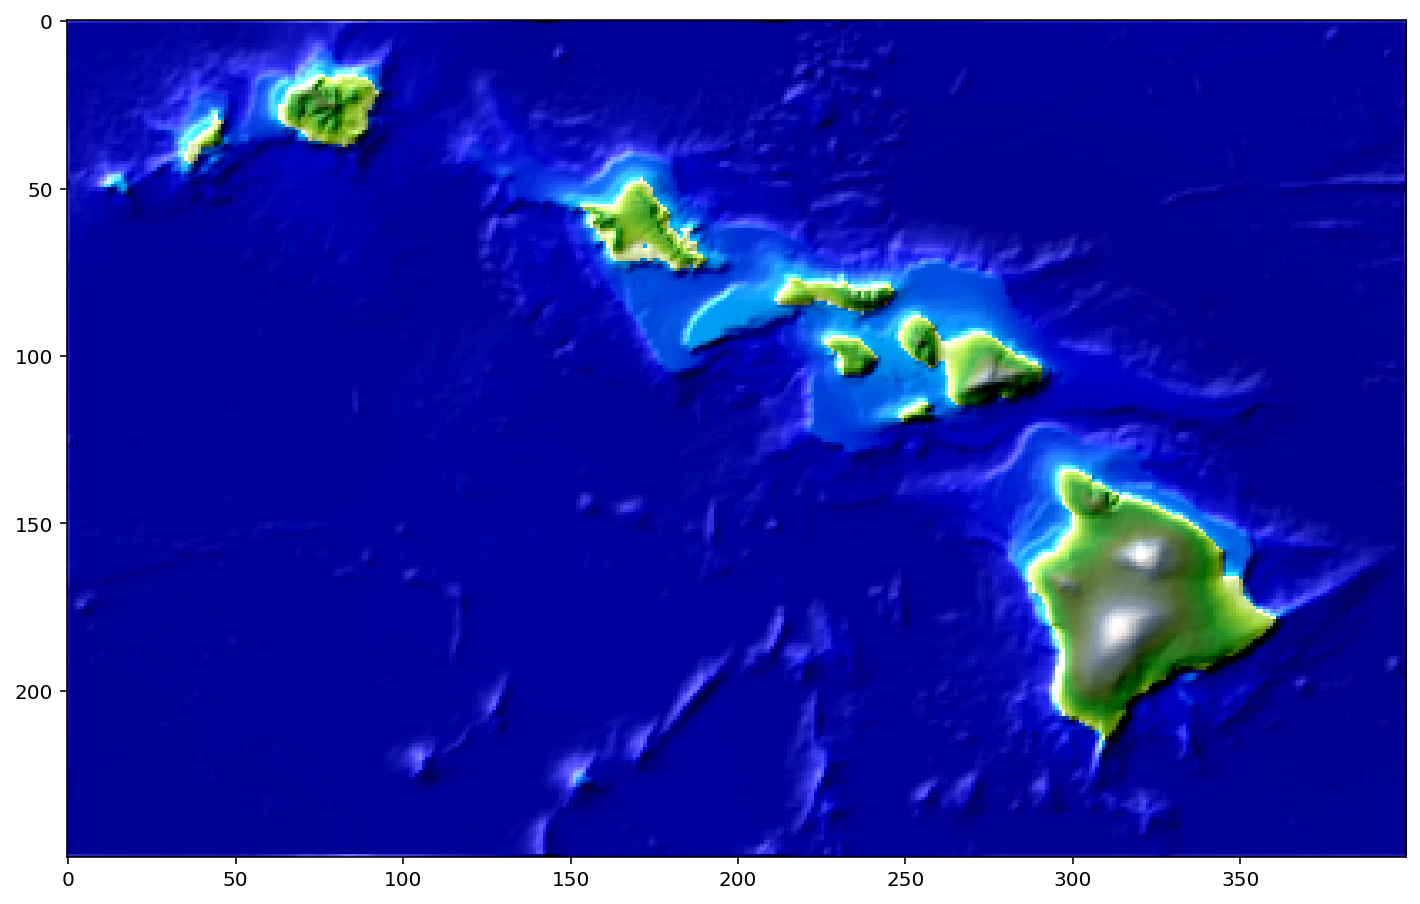

In [2]:
# Load Hawaii
map_elevation = loadRegionMap(region='hawaii', dataset='TBI', minutes_per_node=1, image_folder='img/02/')
data_elevation_sqrt = np.power(np.abs(map_elevation.getDataFlat() * 1.0), 0.5) * np.sign(map_elevation.getDataFlat())
data_elevation_sqrt = data_elevation_sqrt / max(data_elevation_sqrt)
map_elevation_sqrt = map_elevation.newChildInstance(
    {
        'values': 'elevation',
        'mods': 'sqrt'
    }, 
    data_elevation_sqrt
)
map_hillshade = getHillshade(map_elevation, 1)

# Display the image & save the image
RasterImage(map_elevation) \
    .addLayer('elevation', map_elevation_sqrt.getDataFlat(), colormap='naturalish') \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().save().final()

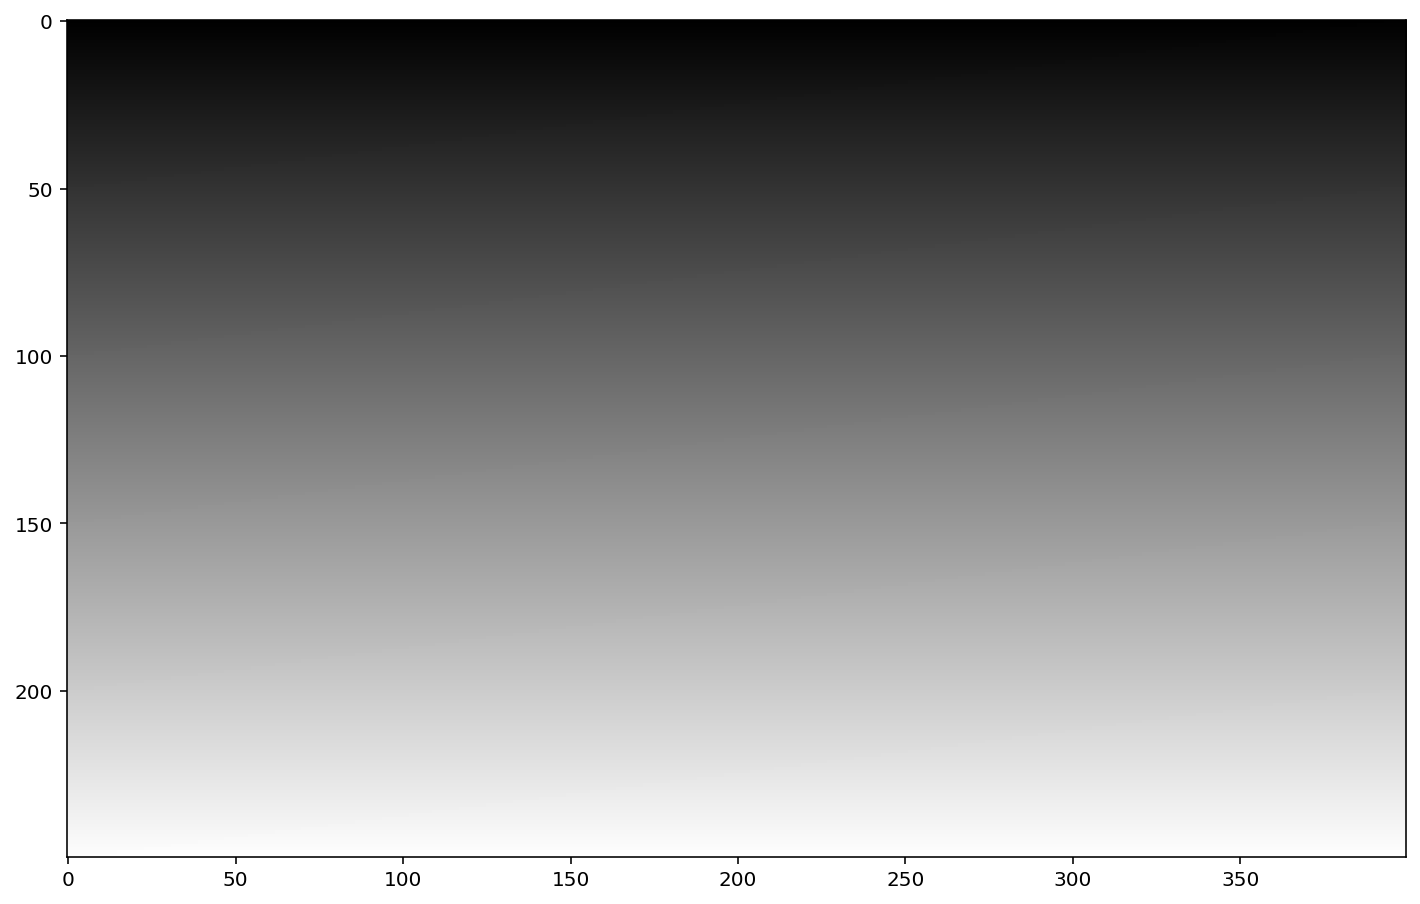

In [3]:
# Method to get the index of each node
nodes_index = getNodesIndex(map_elevation)

RasterImage(map_elevation) \
    .addLayer('index', nodes_index, transforms=['norm']) \
    .display().final()

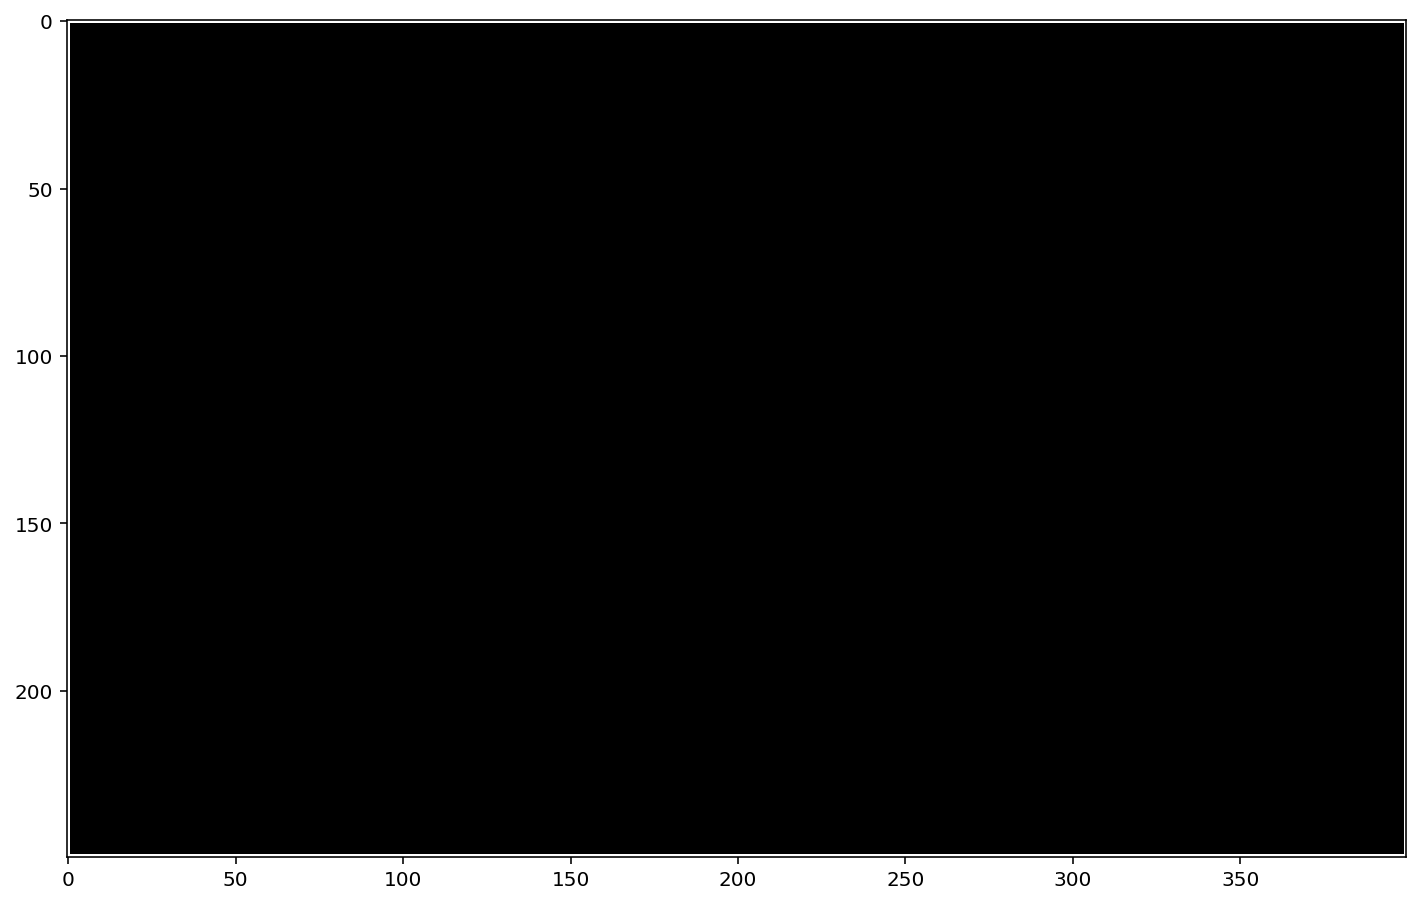

In [4]:
# Method to determine which nodes are at the edge of the map
# It is useful for ignoring "neighboring" nodes that shouldn't be counted in algorithms   
nodes_on_map_edge = getNodesOnMapEdge(map_elevation)

RasterImage(map_elevation) \
    .addLayer('mapedge', nodes_on_map_edge) \
    .display().final()

nodes_value


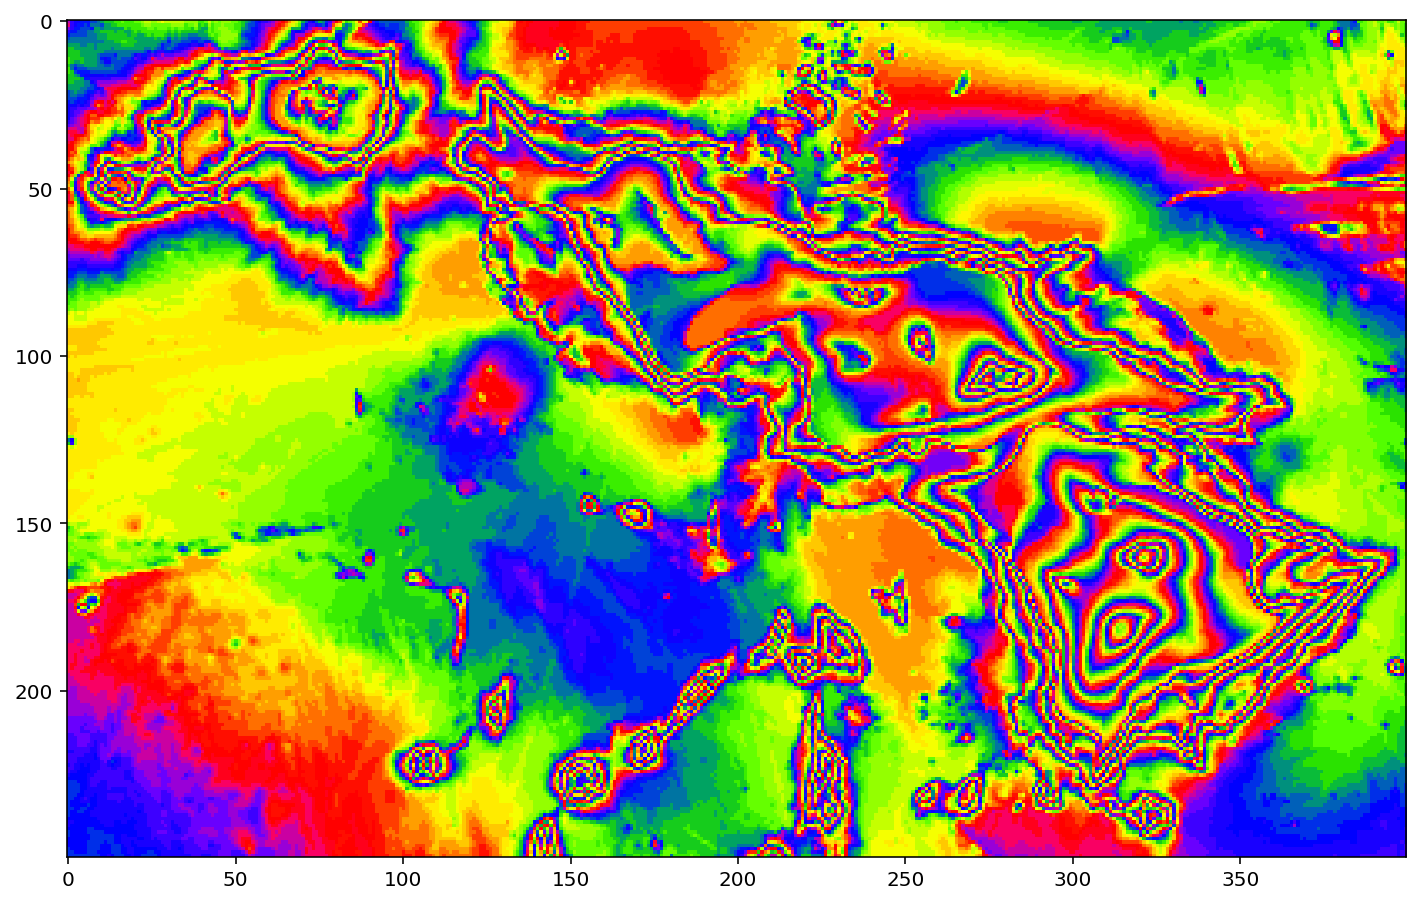

nodes_highest_neighbor_value_so_far


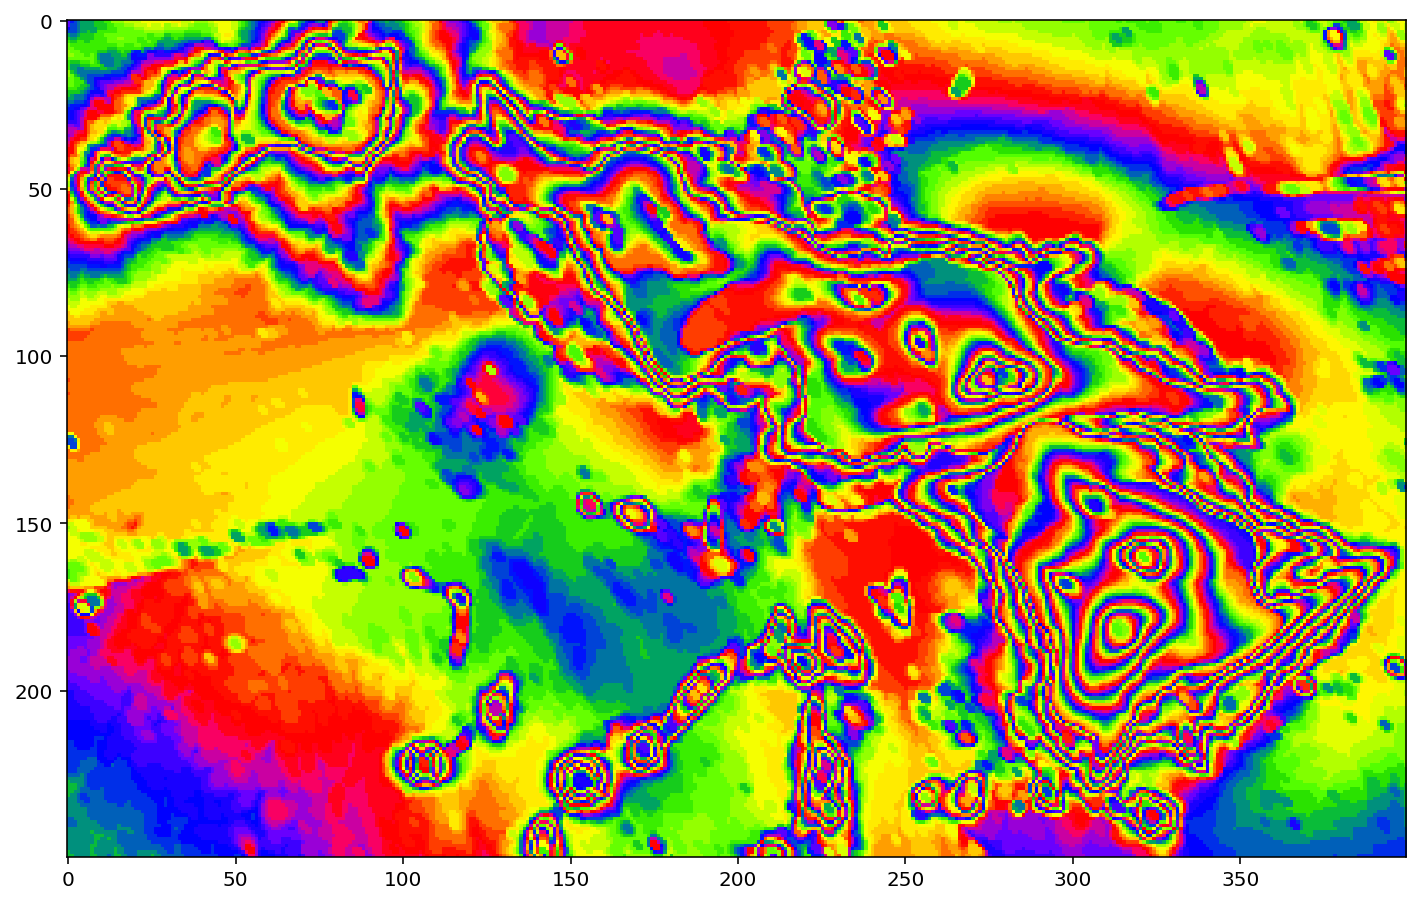

nodes_highest_neighbor_index


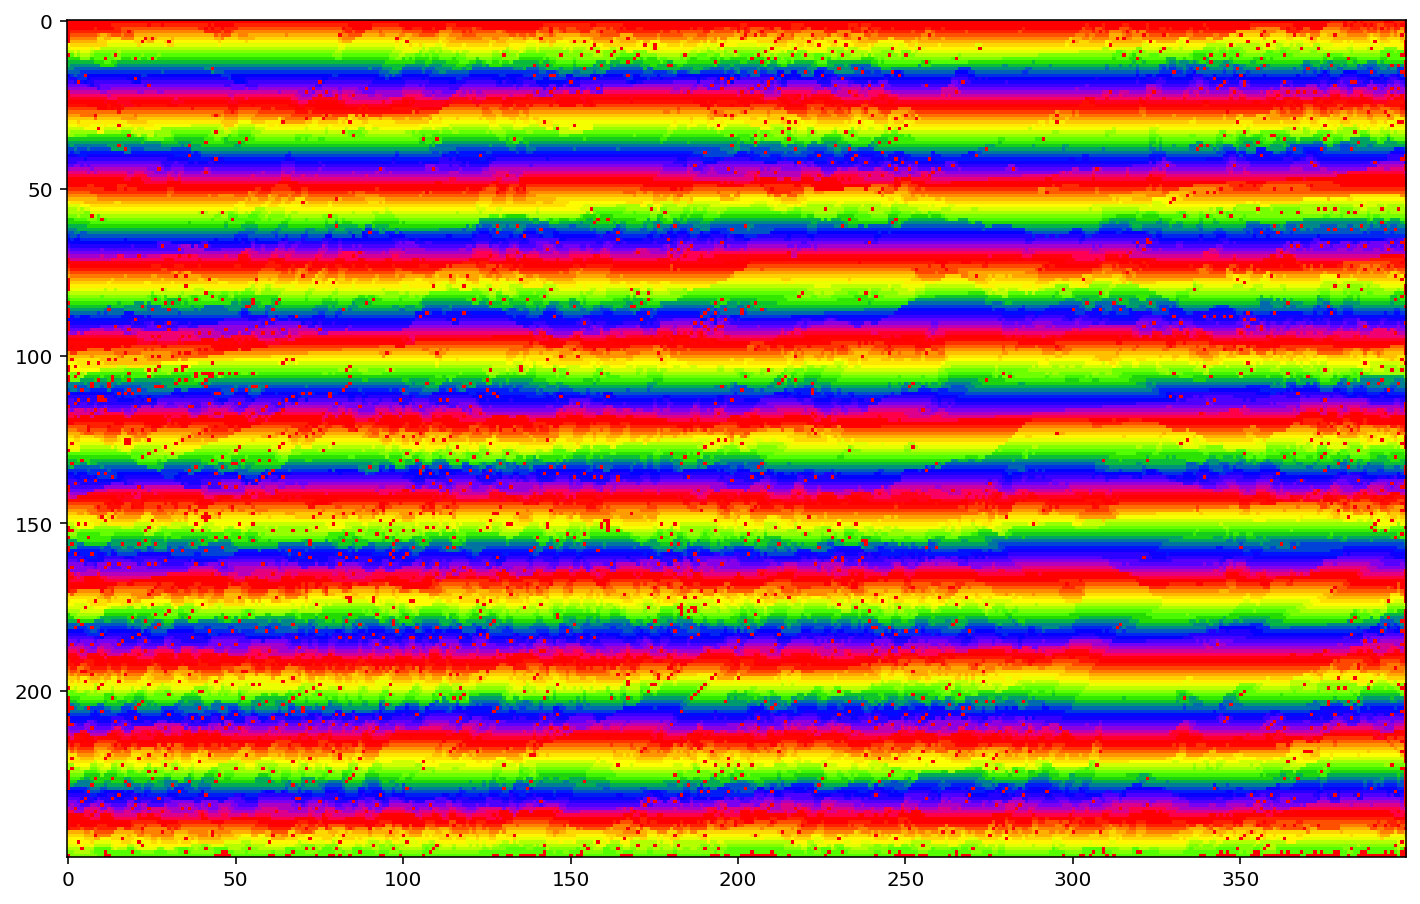

In [5]:
# Test out getting the highest neighbor
map_instance = map_elevation
radius = 1
wrap = False

nodes_value = map_instance.getDataFlat()
nodes_highest_neighbor_value_so_far = map_instance.getDataFlat()
gridded_node_index = nodes_index.reshape(map_instance.getDims())
gridded_value = map_instance.getDataMatrix()
nodes_highest_neighbor_index = np.full(map_instance.getNumNodes(), -1)

for x in range(-radius, radius+1):
    for y in range(-radius, radius+1):
        if (x + y == 0):
            continue
        # For neighboring nodes, find out if they are higher than the node
        nodes_neighbor_value = np.roll(np.roll(gridded_value, x, 0), y, 1).flatten()
        nodes_neighbor_is_higher = nodes_neighbor_value > nodes_highest_neighbor_value_so_far 

        # Remove higher node designations for neighbors that are on the edge
        if (not wrap):
            nodes_neighbor_on_map_edge = np.roll(np.roll(nodes_on_map_edge.reshape(map_instance.getDims()), x, 0), y, 1).flatten()
            nodes_neighbor_is_higher[nodes_neighbor_on_map_edge] = False
        
        # Record the index of the higher neighboring node
        nodes_neighbor_index = np.roll(np.roll(gridded_node_index, x, 0), y, 1).flatten()
        nodes_highest_neighbor_index[nodes_neighbor_is_higher] = nodes_neighbor_index[nodes_neighbor_is_higher]
        nodes_highest_neighbor_value_so_far[nodes_neighbor_is_higher] = nodes_neighbor_value[nodes_neighbor_is_higher]

print('nodes_value')
RasterImage(map_elevation) \
    .addLayer('higher_index', nodes_value, colormap='prism', transforms=['norm']) \
    .display().final()
print('nodes_highest_neighbor_value_so_far')
RasterImage(map_elevation) \
    .addLayer('higher_index', nodes_highest_neighbor_value_so_far, colormap='prism', transforms=['norm']) \
    .display().final()
print('nodes_highest_neighbor_index')
RasterImage(map_elevation) \
    .addLayer('higher_index', nodes_highest_neighbor_index, colormap='prism', transforms=['norm']) \
    .display().final()

nodes_highest_neighbor_index
All of the black dots are local peaks


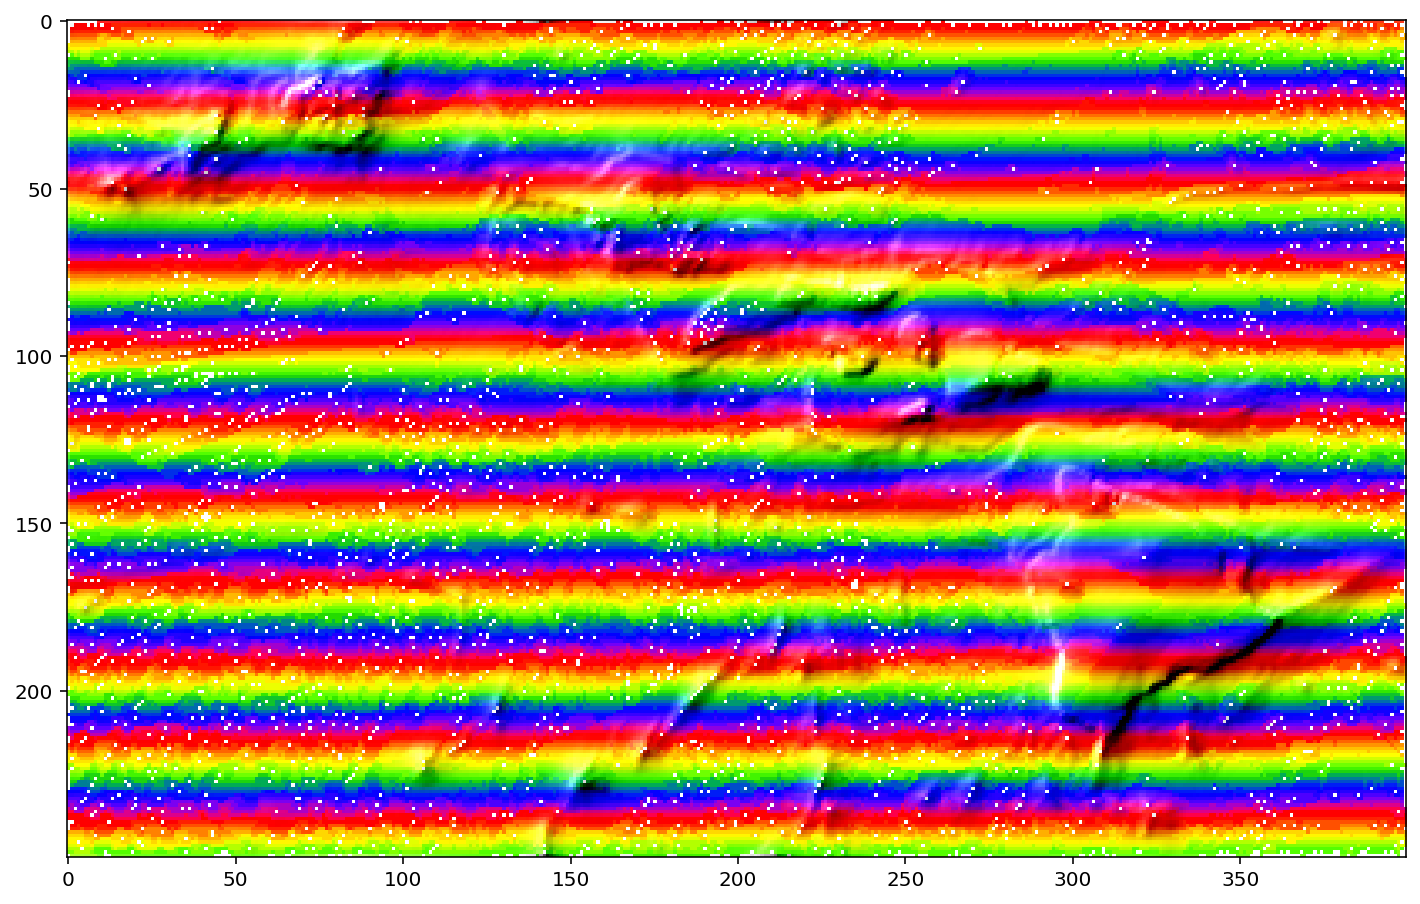

In [6]:
# Move to a library getHighestNeighbor function
map_highest_neighbor_index = getHighestNeighbor(map_elevation)

print('nodes_highest_neighbor_index')
print('All of the black dots are local peaks')
RasterImage(map_elevation) \
    .addLayer('higher_index', map_highest_neighbor_index.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('peak', map_highest_neighbor_index.getDataFlat() == -1, combine='add', opacity=1, dissolve=1) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()


3009 already peaks
86348 updated
74641 updated
57264 updated
37471 updated
18554 updated
5447 updated
379 updated


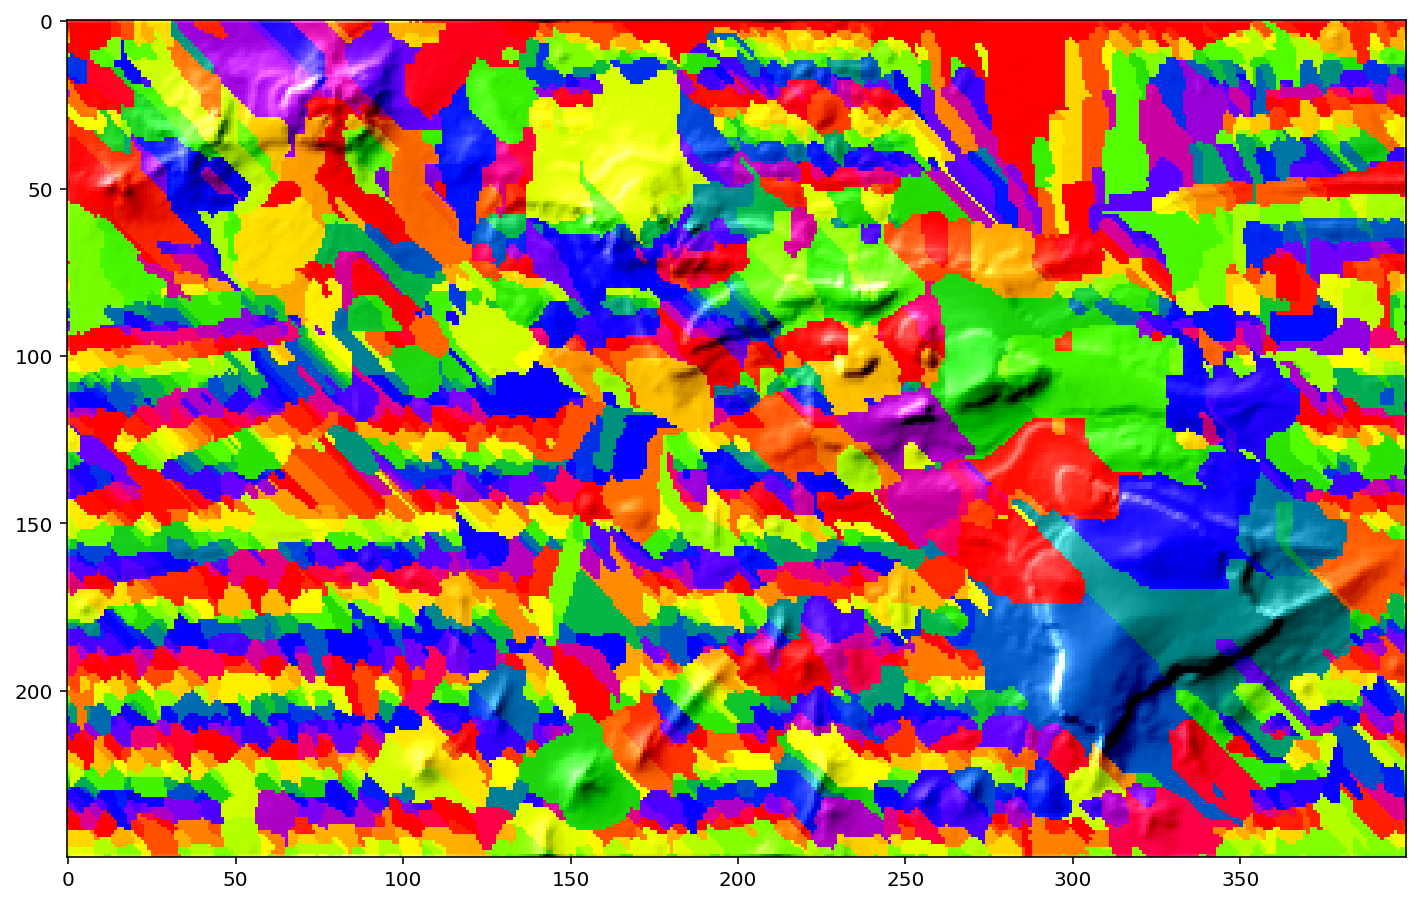

In [7]:
# Get the local peak, the mountain each node would roll up to
map_local_peak = getLocalPeaks(map_highest_neighbor_index, True)

RasterImage(map_elevation) \
    .addLayer('higher_index', map_local_peak.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

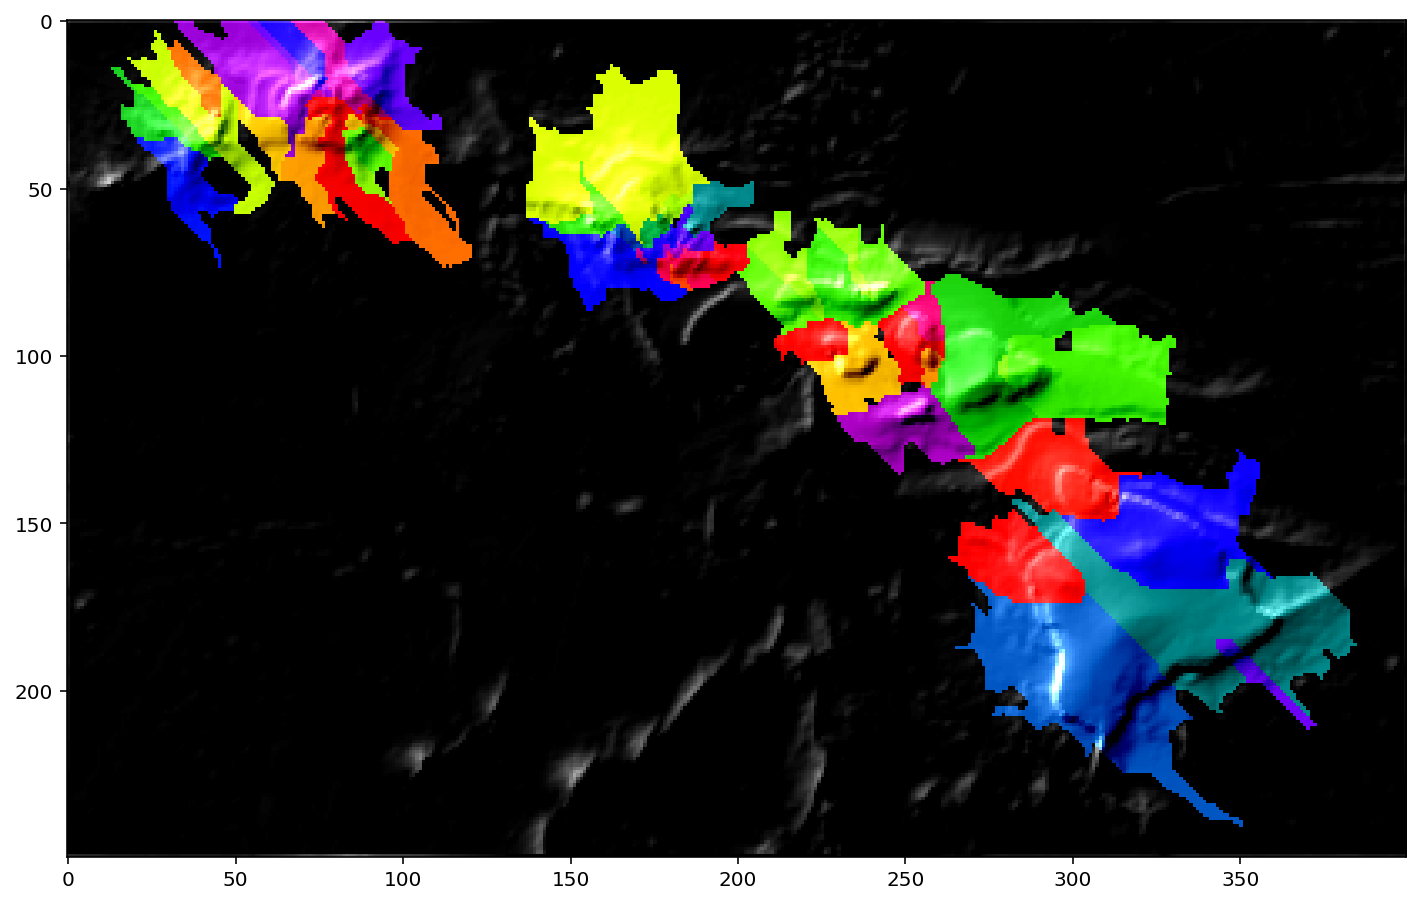

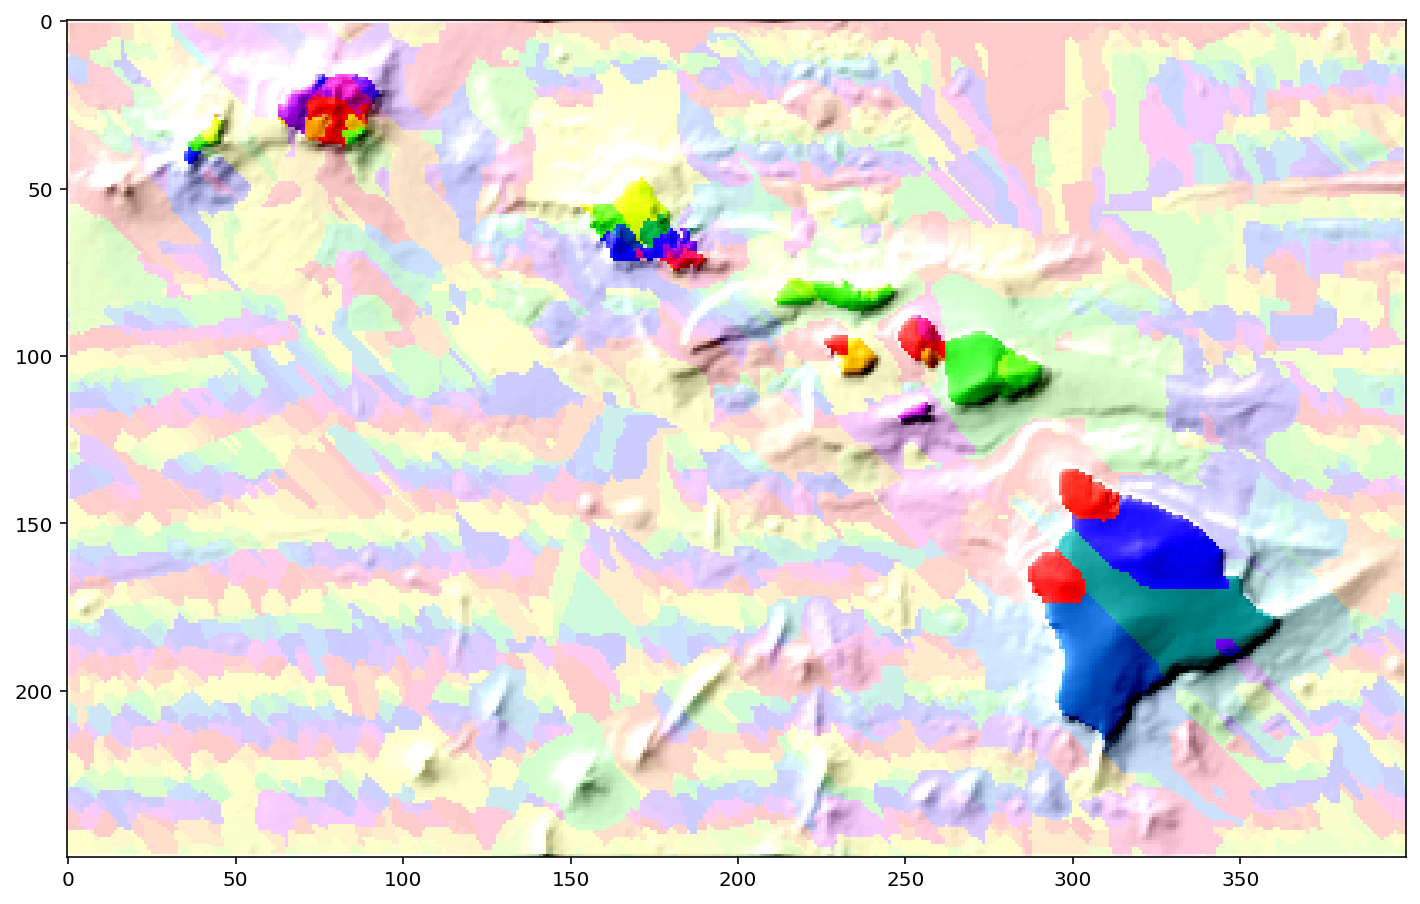

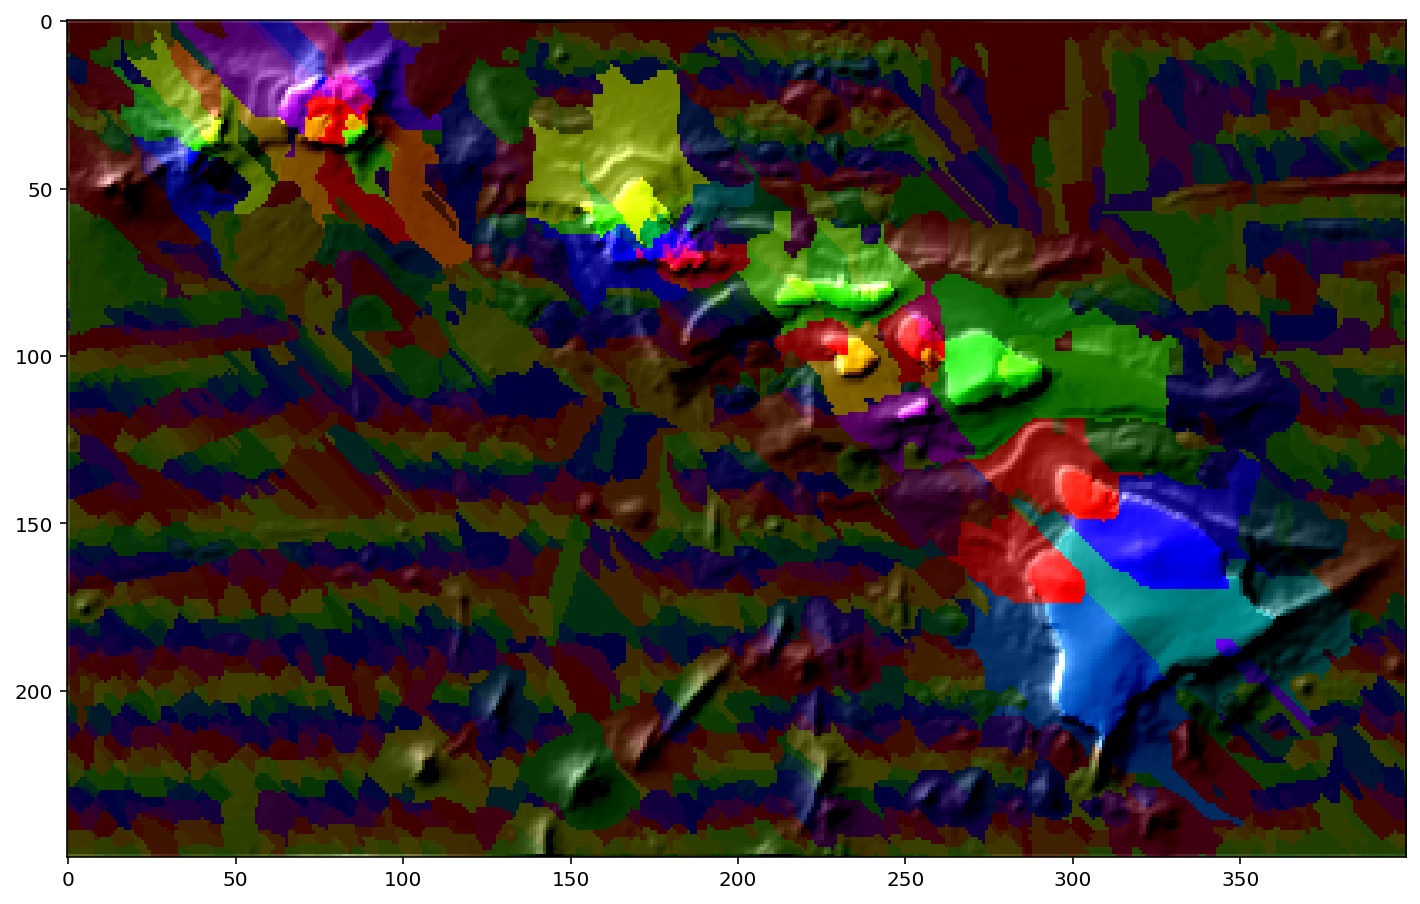

In [8]:
# Try a few other ways to view the mountains in Hawaii

# Only show nodes that roll up to a mountain above sea level
nodes_local_peak_is_above_sealevel = map_elevation.getDataFlat()[map_local_peak.getDataFlat()] > 0
RasterImage(map_elevation) \
    .addLayer('higher_index', map_local_peak.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('hasoverwaterpeak', nodes_local_peak_is_above_sealevel, combine='multiply') \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

# Or brighten the nodes below sea level
RasterImage(map_elevation) \
    .addLayer('higher_index', map_local_peak.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('brightseas', 1.6, nodes_selected=map_elevation.getDataFlat() < 0, combine='add', dissolve=.25) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .display().final()

# A combination of both
RasterImage(map_elevation) \
    .addLayer('higher_index', map_local_peak.getDataFlat(), colormap='prism', transforms=['norm']) \
    .addLayer('hasoverwaterpeak', nodes_local_peak_is_above_sealevel * 0.5 + 0.5, transforms=[], combine='multiply') \
    .addLayer('darkseas', (map_elevation.getDataFlat() > 0) * 0.5 + 0.5, transforms=[], combine='multiply') \
    .addLayer('hillshade', map_hillshade.getDataFlat(), transforms=[], combine='add', opacity=1, dissolve=1) \
    .display().final()

# None of this is quite working out -- let's try drawing borders between regions instead